# Believer-Skeptic Models

In [3]:
from __future__ import division
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from numpy.random import sample as rs
from copy import deepcopy
#from ADMCode import qlearn

%matplotlib inline

In [4]:
homedir = os.path.expanduser('~')
igtData = pd.read_csv(os.path.join("../data/IGTCards.csv"))

In [5]:
class IowaGamblingTask(object):
    """ defines a multi-armed bandit task

    ::Arguments::
        
    """
    def __init__(self, feedback, nblocks=1):

        if nblocks>1:
            feedback = feedback.append([feedback]*(nblocks-1)).reset_index()

        feedback.rename(columns={'index':'t'}, inplace=True)
        self.feedback = feedback

        self.names = np.sort(self.feedback.columns.values)
        self.ntrials=self.feedback.shape[0]

        self.choices, self.all_traces = [], []
        self.rts={k:[] for k in self.names}

        self.qdict={k:[0] for k in self.names}
        self.choice_prob={k:[1/self.names.size] for k in self.names}


    def get_feedback(self, trial, action_ix):

        choice_name = self.names[action_ix]
        return self.feedback.loc[trial, choice_name]


In [6]:
p={'vd':np.asarray([.7]*4), 'vi':np.asarray([.25]*4), 'a':.25, 'tr':.3, 'xb':.00005}
p

{'a': 0.25,
 'tr': 0.3,
 'vd': array([ 0.7,  0.7,  0.7,  0.7]),
 'vi': array([ 0.25,  0.25,  0.25,  0.25]),
 'xb': 5e-05}

In [7]:
def play_IGT(p, feedback, alphaGo=.1, alphaNo=.1, beta=.2, nblocks=2, singleProcess=True):
    """ 
    ::Arguments::
        p (dict): parameter dictionary for accumulator
        feedback (dataframe): IGT card deck values
        alphaGo (float): learning rate for vd (direct pathway)
        alphaNo (float): learning rate for vi (indirect pathway)
        beta (float): inverse temperature parameter
        nblocks (int): number of IGT blocks to simulate
        singleProcess (bool): if true simulate accumulator with v = v_d - v_i
        
    ::Returns::
        qpDF, trialwise Q/P values for each IGT deck
        agentDF, trialwise choice, response time, and drift-rates (vd, vi)
    """

    names = np.sort(feedback.columns.values)
    nact = len(names)
    actions = np.arange(nact)
    IGT = IowaGamblingTask(feedback, nblocks=nblocks)
    ntrials=IGT.feedback.shape[0]
    
    Qmatrix = np.ones((ntrials, nact))*.05
    Pmatrix=np.zeros_like(Qmatrix)
    Qvalues = Qmatrix[0, :]
    Pvalues = np.array([1/nact]*nact)
    
    agent = np.zeros((ntrials, 3 + nact*3))
    agent[0, 3:] = np.hstack([p['vd'], p['vi'], p['vd']-p['vi']])
    
    #driftRates = np.zeros(ntrials, )
    for t in range(ntrials):
        # select bandit arm (action)
        act_i, rt, rt_i = simulate_multirace(p, singleProcess=singleProcess)
        agent[t, :3] = act_i, rt, rt_i
        
        # observe feedback
        r = IGT.get_feedback(t, act_i)
        
        # get expected value 
        Qexpected = Qvalues[act_i]
        
        # get prediction error
        RPE = r - Qexpected
        
        # get alpha for Q-value update
        alpha = alphaGo
        if RPE<0: 
            alpha = alphaNo
        
        # update expected value and store in Qvalues array
        # update v_d or v_i (depending on RPE sign)
        Qvalues[act_i] = update_Qi(Qexpected, RPE, alpha=alpha)
        
        # update action selection probabilities 
        Pvalues = update_Pall(Qvalues, beta)
        
        # store new values in output matrices
        Qmatrix[t, :] = Qvalues
        Pmatrix[t, :] = Pvalues
        
        # re-scale drift-rates by change in Softmax probability
        deltaP = Pmatrix[t] - Pmatrix[t-1]
        p = update_drift(p, deltaP, alphaGo, alphaNo)
        agent[t, 3:] = np.hstack([p['vd'], p['vi'], p['vd']-p['vi']])
        
    return make_output_df(Qmatrix, Pmatrix, agent)

In [8]:
def temporal_dynamics(p, t):
    return np.cosh(p['xb'] * t)


def simulate_multirace(p, dt=.001, si=.1, tb=1.5, singleProcess=False):

    temporal_dynamics = lambda p, t: np.cosh(p['xb'] * t)
    
    nresp = p['vd'].size
    dx = si * np.sqrt(dt)

    nTime = np.ceil((tb-p['tr'])/dt).astype(int)
    xtb = temporal_dynamics(p, np.cumsum([dt]*nTime))

    if singleProcess:
        Pdelta = .5 * (1 + ((p['vd']-p['vi']) * np.sqrt(dt))/si)
        execution = xtb * np.cumsum(np.where((rs((nresp, nTime)).T < Pdelta), dx, -dx).T, axis=1)
    else:
        Pd = .5 * (1 + (p['vd'] * np.sqrt(dt))/si)
        Pi = .5 * (1 + (p['vi'] * np.sqrt(dt))/si)
        direct = xtb * np.where((rs((nresp, nTime)).T < Pd),dx,-dx).T
        indirect = np.where((rs((nresp, nTime)).T < Pi),dx,-dx).T
        execution = np.cumsum(direct-indirect, axis=1)
    act_ix, rt, rt_ix = analyze_multiresponse(execution, p, dt=dt)    
    return act_ix, rt, rt_ix 


def analyze_multiresponse(execution, p, dt=.001):
    """analyze multi-race execution processes
    """
    nsteps_to_rt = np.argmax((execution.T>=p['a']).T, axis=1)
    rts = p['tr'] + nsteps_to_rt*dt
    
    # set non responses to 999
    rts[rts==p['tr']]=999
    
    # get accumulator with fastest RT (winner) in each cond
    act_ix = np.argmin(rts)
    rt = rts[act_ix]
    rt_ix = np.ceil((rt-p['tr'])/dt).astype(int)
    
    return act_ix, rt, rt_ix


def update_drift(p, delta_prob, alphaGo=.3, alphaNo=.3):
    """ update direct & indirect drift-rates for all IGT actions
    """
    vd_exp = p['vd']
    vi_exp = p['vi']
    p['vd'] = vd_exp + (alphaGo * delta_prob)
    p['vi'] = vi_exp + (alphaNo * -delta_prob)
    return p


def update_Qi(Qval, RPE, alpha=.3):
    """ update q-value of selected action, given RPE and alpha
    """
    QUpdate = Qval + alpha*RPE
    return QUpdate


def update_Pall(Qvector, beta):
    """ update vector of action selection probabilities given
    associated q-values
    """
    return np.array([np.exp(beta*Q_i) / np.sum(np.exp(beta * Qvector)) for Q_i in Qvector])


def make_output_df(Qmatrix, Pmatrix, agent):
    """ generate output dataframe with trialwise Q and P measures 
    for each "card" in IGT, as well as choice selection, rt, & vd, vi (drift-rates)
    ::Arguments::
        Qmatrix (ndarray): q-value array with dims [Ntrials x Ncards] 
        Pmatrix (ndarray): softmax prob array with dims [Ntrials x Ncards] 
        agent (ndarray): array with behavior and agent vd and vi (drift rates)
    ::Returns::
        df (DataFrame): pandas df containing Q and SoftmaxP values for each card
        agentdf (DataFrame): DF of agent (with non-response trials removed)
    """
    actions = np.arange(Qmatrix.shape[1])
    df = pd.concat([pd.DataFrame(dat) for dat in [Qmatrix, Pmatrix]], axis=1)
    cols = [['{}{}'.format(x,c) for c in actions] for x in ['q', 'p']]
    df.columns = np.hstack(cols)
    df.insert(0, 'trial', np.arange(1, df.shape[0]+1))
    vdCols = ['vd{}'.format(i) for i in range(actions.size)]
    viCols = ['vi{}'.format(i) for i in range(actions.size)]
    vDeltaCols = ['vDelta{}'.format(i) for i in range(actions.size)]
    agentdf = pd.DataFrame(agent, columns=['choice', 'rt', 'rt_i']+vdCols+viCols+vDeltaCols)
    RT_ix = agentdf.rt[agentdf.rt>1.5].index.values
    agentdf.iloc[RT_ix, :] = np.nan
    agentdf = agentdf.dropna()
    return df, agentdf

In [15]:
p={'vd':np.asarray([.7]*4), 'vi':np.asarray([.25]*4), 'a':.25, 'tr':.3, 'xb':.00005}

aGo=.1
aNo=.1

outdf, agentdf = play_IGT(p, feedback=igtData, beta=.09, nblocks=2, 
                          alphaGo=aGo, alphaNo=aNo, singleProcess=0)
# print(agentdf.shape)
print(agentdf.rt.mean())
agentdf.iloc[:, :].choice.value_counts().sort_index()

0.6150099999999997


0.0    20
1.0    41
2.0    22
3.0    17
Name: choice, dtype: int64

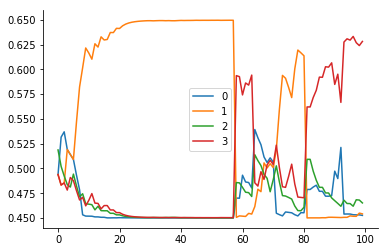

In [16]:
_=[agentdf['vDelta{}'.format(i)].plot(label=str(i)) for i in range(4)]
_=plt.legend()
sns.despine()

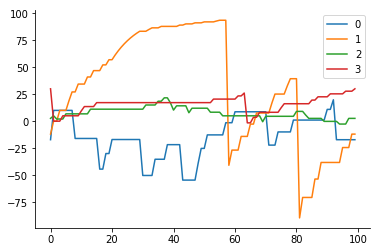

In [17]:
_=[outdf['q{}'.format(i)].plot(label=str(i)) for i in range(4)]
_=plt.legend()
sns.despine()

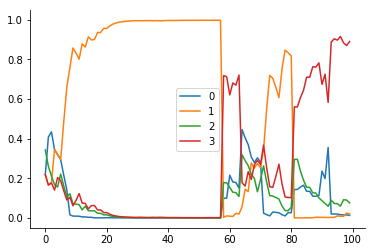

In [20]:
_=[outdf['p{}'.format(i)].plot(label=str(i)) for i in range(4)]
_=plt.legend()
sns.despine()

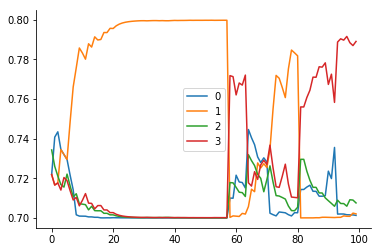

In [21]:
_=[agentdf['vd{}'.format(i)].plot(label=str(i)) for i in range(4)]
_=plt.legend()
sns.despine()

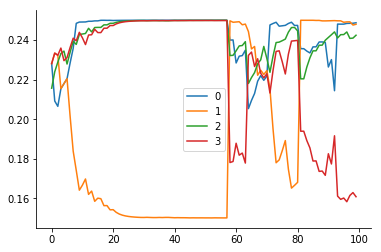

In [22]:
_=[agentdf['vi{}'.format(i)].plot(label=str(i)) for i in range(4)]
_=plt.legend()
sns.despine()

In [2]:
single_process=0
si=.1
tb=1.0
dt=.001
nresp = p['vd'].size
dx = si * np.sqrt(dt)

nTime = np.ceil((tb-p['tr'])/dt).astype(int)
xtb = temporal_dynamics(p, np.cumsum([dt]*nTime))

if single_process:
    Pdelta = .5 * (1 + ((p['vd']-p['vi']) * np.sqrt(dt))/si)
    execution = xtb * np.cumsum(np.where((rs((nresp, nTime)).T < Pdelta), dx, -dx).T, axis=1)
else:
    Pd = .5 * (1 + (p['vd'] * np.sqrt(dt))/si)
    Pi = .5 * (1 + (p['vi'] * np.sqrt(dt))/si)
    direct = xtb * np.where((rs((nresp, nTime)).T < Pd),dx,-dx).T
    indirect = np.where((rs((nresp, nTime)).T < Pi),dx,-dx).T
    execution = np.cumsum(direct-indirect, axis=1)
act_ix, rt, rt_ix = analyze_multiresponse(execution, p)    

nsteps_to_rt = np.argmax((execution.T>=p['a']).T, axis=1)
rts = p['tr'] + nsteps_to_rt*dt

# set non responses to 999
rts[rts==p['tr']]=999

# get accumulator with fastest RT (winner) in each cond
act_ix = np.argmin(rts)
winner, rt=act_ix, rts[act_ix]
rt_ix = np.ceil((rt-p['tr'])/dt).astype(int)
actions = np.arange(nresp)
losers = actions[actions!=act_ix]
print(act_ix)
plt.plot(execution[act_ix][:rt_ix], color='b')
for l in losers:
    plt.plot(execution[l][:rt_ix], color='r', alpha=.3)
sns.despine()

NameError: name 'p' is not defined